In [25]:
%matplotlib inline 
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import warnings; warnings.simplefilter('ignore') #not the best, but helps when zeros are out of hand

#### load lidar data

In [26]:
fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})

    #time
ds['time'] = ds['time'].dt.strftime('%d-%b-%Y')

    #snow depth
ds['snow'] = ds.snow/10 #convert to cm
ds['snow'] = ds.snow.where(ds.snow>=0) #include zeros, or don't..... change HERE
ds['snow'] = ds.snow.where(ds.mask==1)

    #zeros
ds['zeros']= xr.where((ds.snow==0.0), 1, 0) #(ds.snow>=0) & (ds.snow<=0.1) ds.snow>0, 0, 1
ds['zeros'] = ds.zeros.where(ds.mask==1)

#     #negatives
# ds['neg']= xr.where(ds.snow<0, 1, 0) #(ds.snow>=0) & (ds.snow<=0.1)
# ds['neg'] = ds.zeros.where(ds.mask==1)

    #attributes
ds.x.attrs['long_name']='Easting'; ds.x.attrs['units']='m'
ds.y.attrs['long_name']='Northing'; ds.y.attrs['units']='m'
ds.close()

#### run all or peak?
- if comment = running all flights
- if uncommented = running peak
- or run everything for 2016 average year 

In [27]:
# peak = [0,7,18,30,42,49] 
# ds = ds.isel(time=peak)
# ds

# sxtn = np.arange(27, 33, 1)
# ds = ds.isel(time=sxtn)
# ds.time

fttn = np.arange(17, 23, 1)
ds = ds.isel(time=fttn)
ds.time

<xarray.DataArray 'time' (time: 6)>
array(['18-Feb-2015', '06-Mar-2015', '25-Mar-2015', '03-Apr-2015',
       '09-Apr-2015', '15-Apr-2015'], dtype=object)
Coordinates:
  * time     (time) object '18-Feb-2015' '06-Mar-2015' ... '15-Apr-2015'

#### load terrain data

In [28]:
fname = '~/Documents/research/sierra/data/20m_analysis/terrain.nc' #BSU
ts = xr.open_dataset(fname,  chunks={'x':1000,'y':1000}).drop(('dem','veg'))
ts.close()

#### confirmation plots

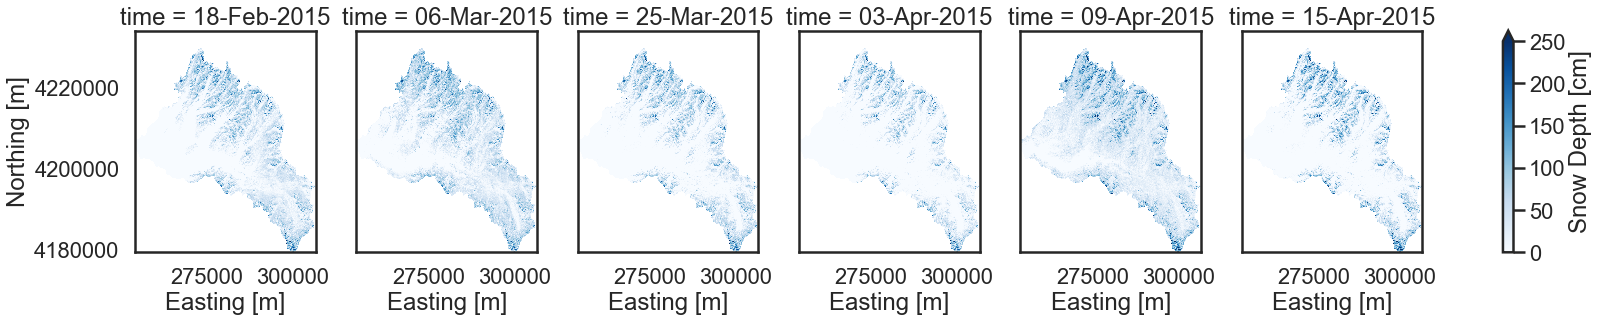

In [29]:
#snow depths
ds.snow.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='Blues', vmax=250, cbar_kwargs={'label': 'Snow Depth [cm]'}, figsize=(25,5))
# plt.savefig('../figs/depths.png', dpi=300)

#### Zeros in the dataset (gray= 0 cm snow depth, blue = >0 cm snow depth)

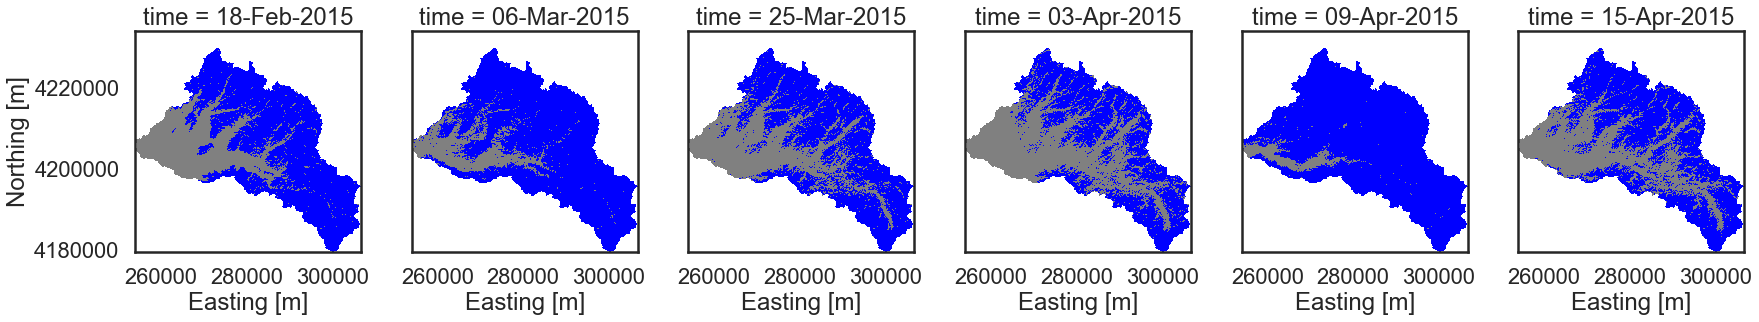

In [30]:
#zeros are ones
ds.zeros.plot.imshow(x='x', y='y', col='time', col_wrap=6, colors=['blue', 'gray'], levels=[0,1,2], figsize=(25,5), add_colorbar=False)#, cbar_kwargs={'label': "zero snow depth (0's = 1)"}, figsize=(25,5))
# plt.savefig('../figs/test.png', dpi=300)

In [31]:
#do stats on SCA
ds['snow'] = ds.snow.where(ds.snow>0)

In [32]:
#standardize
stan = (ds.snow - ds.snow.mean(dim=('x','y'))) / ds.snow.std(dim=('x','y'))
stan

<xarray.DataArray 'snow' (time: 6, y: 2739, x: 2637)>
dask.array<truediv, shape=(6, 2739, 2637), dtype=float64, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
  * time     (time) object '18-Feb-2015' '06-Mar-2015' ... '15-Apr-2015'
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

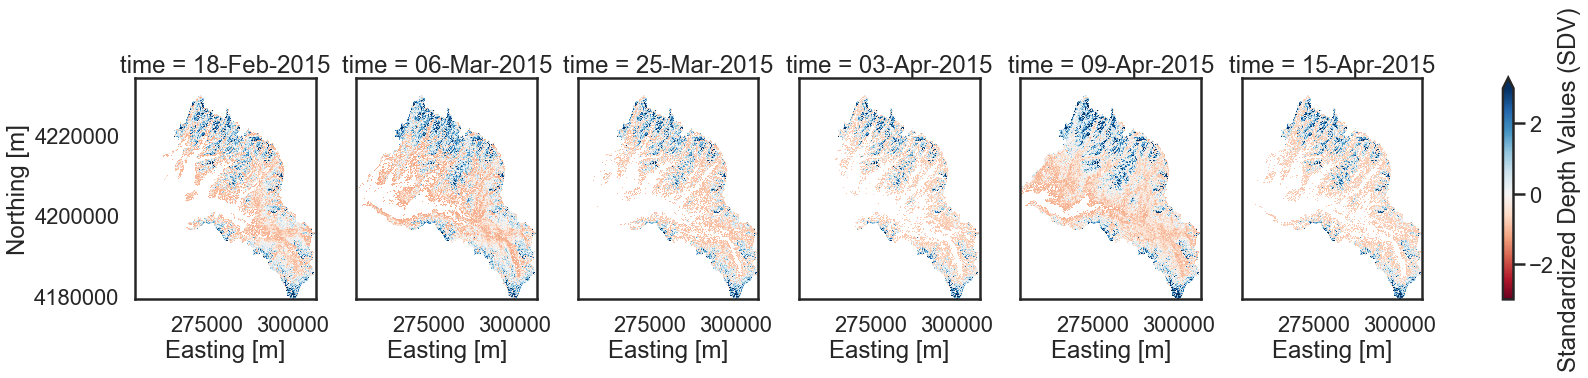

In [33]:
stan.plot.imshow(x='x', y='y', col='time', col_wrap=6, cmap='RdBu', vmin=-3, vmax=3, cbar_kwargs={'label': 'Standardized Depth Values (SDV)'}, figsize=(25,5))
# plt.savefig('../figs/test.png', dpi=300)

In [34]:
#standardize
s = stan.std(dim='time')
print(s.min().values)
print(s.max().values)

0.0
7.784043517894676


In [11]:
s

<xarray.DataArray 'snow' (y: 2739, x: 2637)>
dask.array<sqrt, shape=(2739, 2637), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

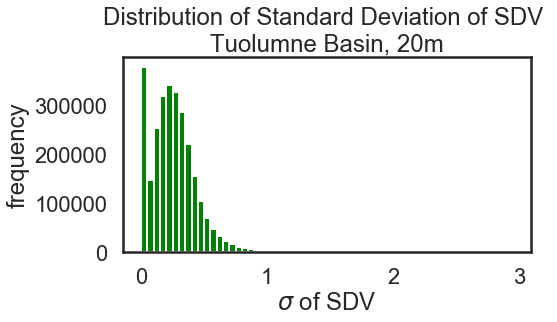

In [45]:
#hist
plt.figure(figsize=(8,5))
bins = np.arange(0,3,0.05)
s_flat = s.values.flatten()
plt.hist(s_flat, bins=bins, color='g')
plt.title('Distribution of Standard Deviation of SDV \nTuolumne Basin, 20m')
plt.xlabel('$\sigma$ of SDV')
plt.ylabel('frequency')
plt.tight_layout()
# plt.savefig('../figs/sig_std_cont_peak_hist_20m.png', dpi=300)
# plt.savefig('../figs/sig_std_cont_2016_hist_20m.png', dpi=300)
plt.savefig('../figs/sig_std_cont_2015_hist_20m.png', dpi=300)

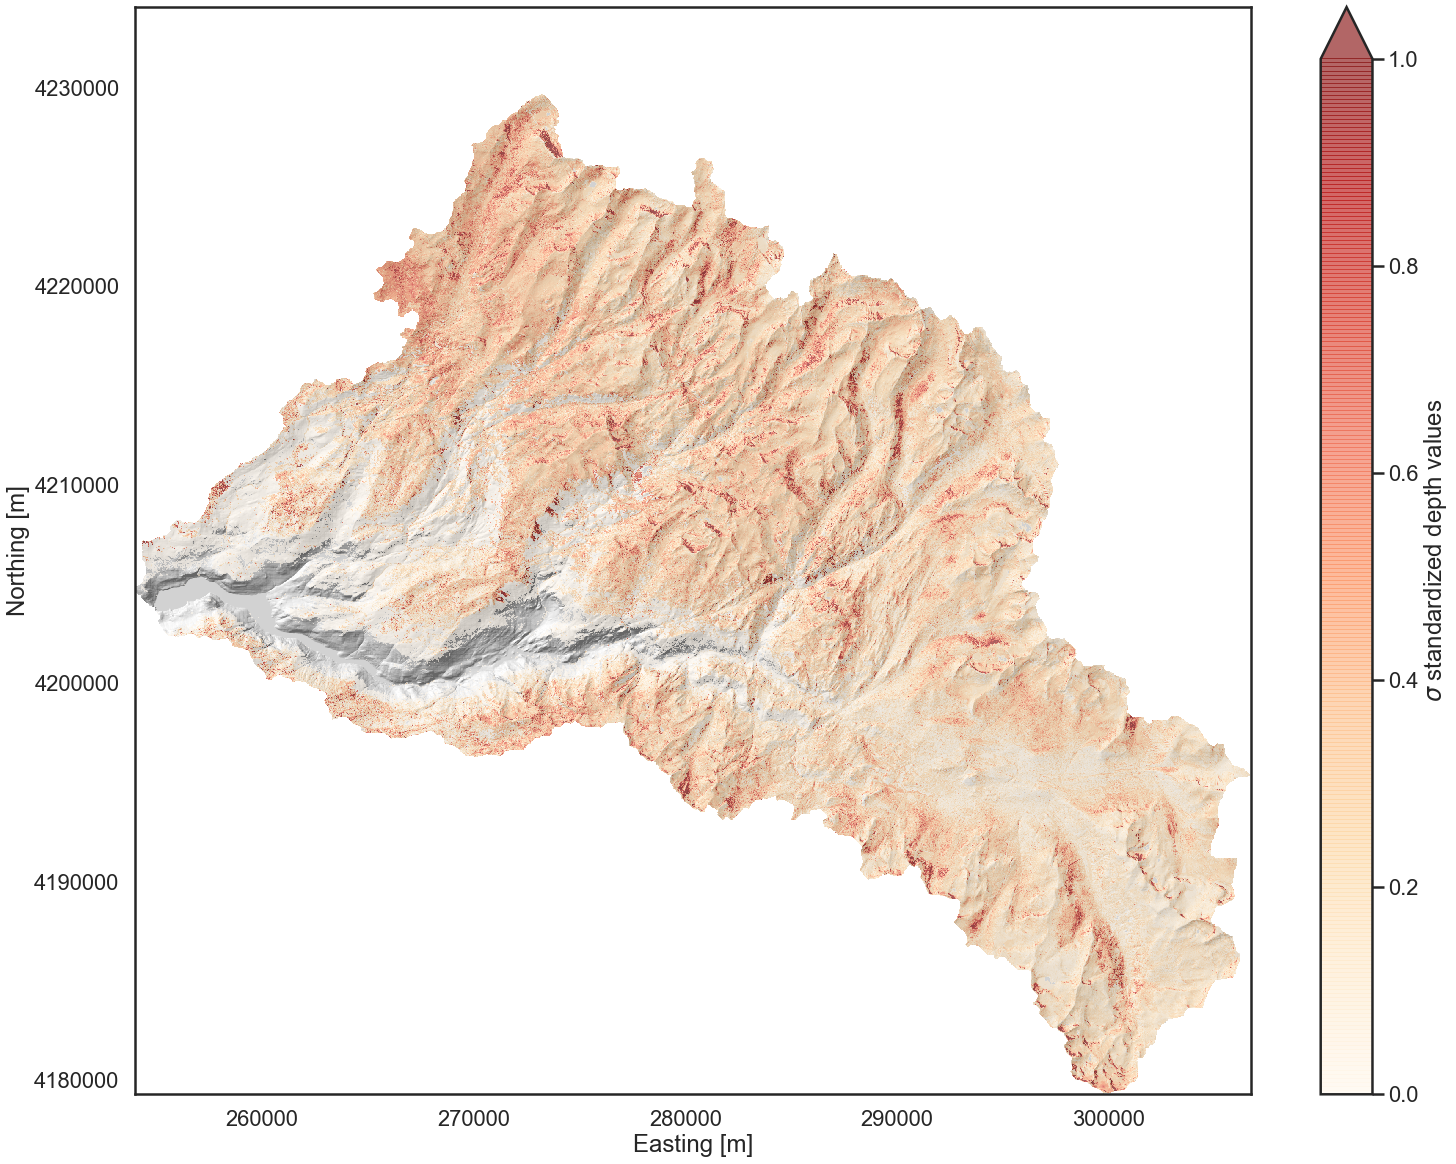

In [35]:
#plot standardize BETTER with S continuous 
plt.figure(figsize=(25,20))
ts.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.6, add_colorbar=False)
s.plot.imshow(x='x', y='y', cmap='OrRd', alpha=.6,  vmin=0, vmax=1, cbar_kwargs={'label': '$\sigma$ standardized depth values'})
# plt.savefig('../figs/sig_std_cont_peak_20m.png', dpi=300)
# plt.savefig('../figs/sig_std_cont_2016_20m.png', dpi=300)
plt.savefig('../figs/sig_std_cont_2015_20m.png', dpi=300)

In [14]:
# s = xr.where(s>=0.5, 1.0, np.nan)

# #plot standardized BETTER WITH S DISCRETE
# plt.figure(figsize=(20,20))
# ts.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.3, add_colorbar=False)
# s.plot.imshow(x='x', y='y', cmap='Reds', vmin= 0, vmax=1.0, add_colorbar=False)#, cbar_kwargs={'label': '$\sigma$ standardized depth values'})
# plt.savefig('../figs/sig_std_disc_peak_20m.png', dpi=300)

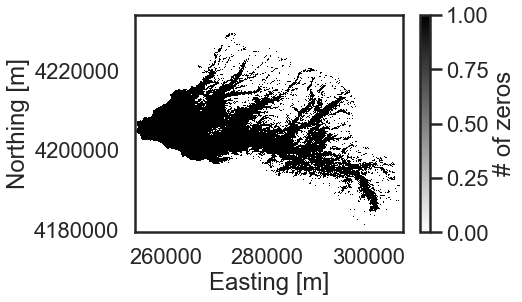

In [36]:
#zeros again
z = ds.zeros.sum(dim='time')
zz = xr.where(z>0, 1, 0)
zz.plot.imshow(x='x', y='y', cmap='binary', cbar_kwargs={'label': '# of zeros'})

In [16]:
zz

<xarray.DataArray 'zeros' (y: 2739, x: 2637)>
dask.array<where, shape=(2739, 2637), dtype=int64, chunksize=(1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float32 254000.0 254020.0 254040.0 ... 306700.0 306720.0
  * y        (y) float32 4234060.0 4234040.0 4234020.0 ... 4179320.0 4179300.0
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>

In [39]:
#subdomain of GRAY and RED Sdt of SDV
d = ds.sel(x=slice(270000, 280000), y=slice(4220000, 4210000)) #snow depth
t = ts.sel(x=slice(270000, 280000), y=slice(4220000, 4210000)) #terrain
d_stan = s.sel(x=slice(270000, 280000), y=slice(4220000, 4210000))
zz_sub = zz.sel(x=slice(270000, 280000), y=slice(4220000, 4210000))
#subdomain size:
print('x direction length {} [m]:'.format(d.x.max().values - d.x.min().values))
print('y direction length {} [m]:'.format(d.y.max().values - d.y.min().values))
print('x direction length {} [km]:'.format((d.x.max().values - d.x.min().values)/1000))
print('y direction length {} [km]:'.format((d.y.max().values - d.y.min().values)/1000))

x direction length 10000.0 [m]:
y direction length 10000.0 [m]:
x direction length 10.0 [km]:
y direction length 10.0 [km]:


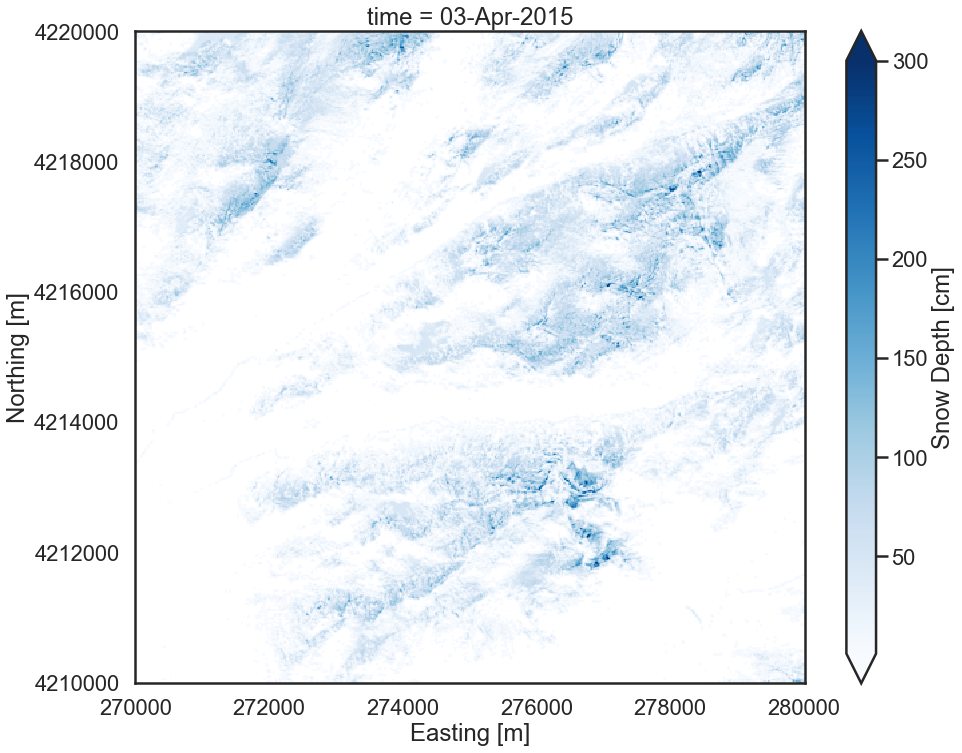

In [40]:
#plot standardize subdomain
plt.figure(figsize=(15,12))
# t.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.6, add_colorbar=False)
d.snow[3].plot.imshow(x='x', y='y', cmap='Blues', vmin= 300, vmax=1, cbar_kwargs={'label': 'Snow Depth [cm]'})

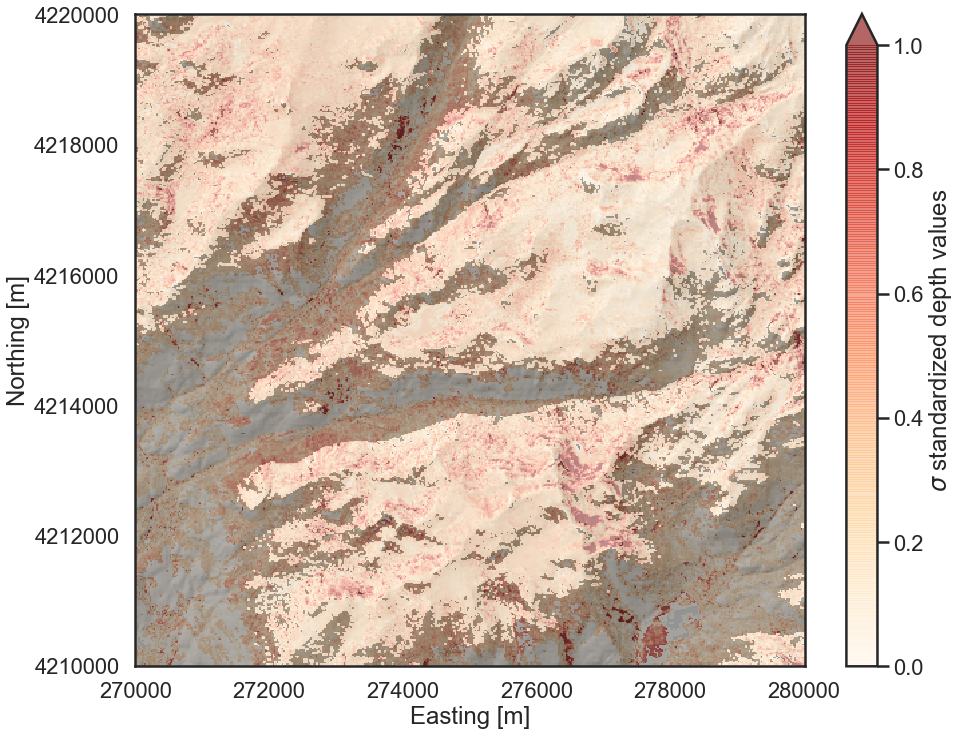

In [41]:
plt.figure(figsize=(15,12))
ts.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.6, add_colorbar=False)
d_stan.plot.imshow(x='x', y='y', cmap='OrRd', alpha=.6, vmin= 0, vmax=1, cbar_kwargs={'label': '$\sigma$ standardized depth values'})
zz_sub.plot.imshow(x='x', y='y', cmap='binary', alpha=.3, add_colorbar=False)
# plt.savefig('../figs/sig_std_subdom_peak_20m.png', dpi=300)
# plt.savefig('../figs/sig_std_subdom_2016_20m.png', dpi=300)
plt.savefig('../figs/sig_std_subdom_2015_20m.png', dpi=300)

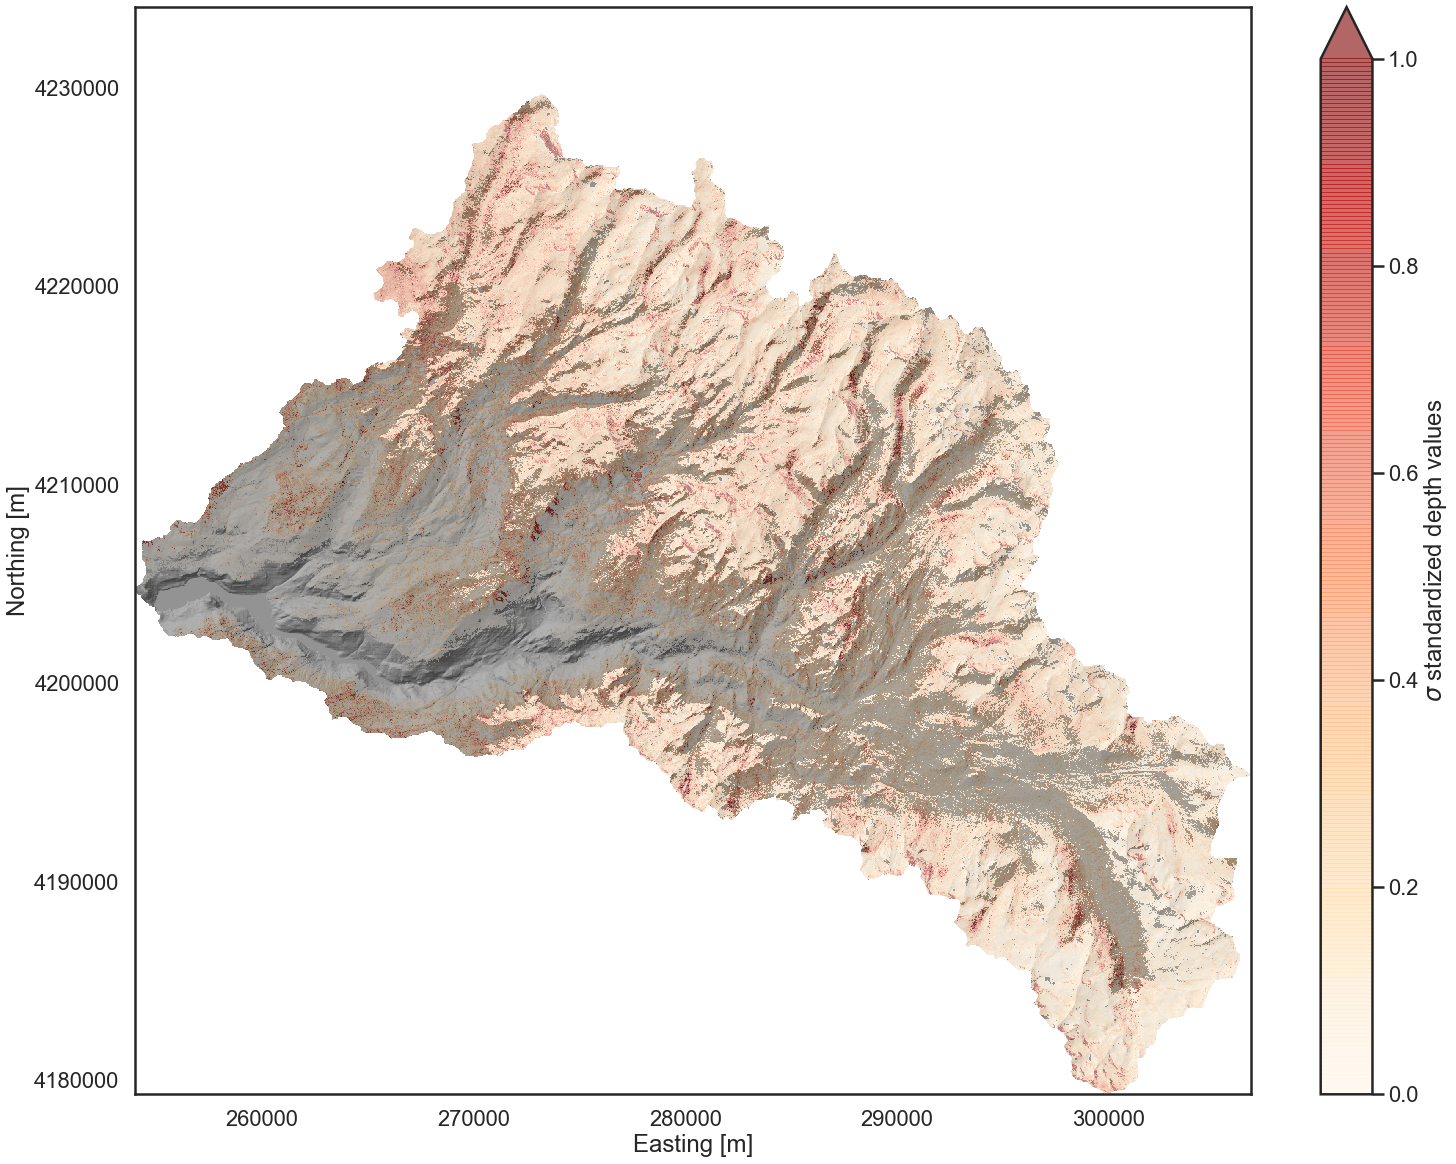

In [42]:
plt.figure(figsize=(25,20))
ts.hillshade.plot.imshow(x='x', y='y', cmap='gray', alpha=.6, add_colorbar=False)
s.plot.imshow(x='x', y='y', cmap='OrRd', alpha=.6,  vmin=0, vmax=1, cbar_kwargs={'label': '$\sigma$ standardized depth values'})
zz.plot.imshow(x='x', y='y', cmap='binary', alpha=.3, add_colorbar=False)
# plt.savefig('../figs/sig_std_cont_wzeros_peak_20m.png', dpi=300)
# plt.savefig('../figs/sig_std_cont_wzeros_2016_20m.png', dpi=300)
plt.savefig('../figs/sig_std_cont_wzeros_2015_20m.png', dpi=300)

In [43]:
#ghetto af..... :/
s_flat = s.values.flatten()
print(s_flat.shape)
s_flat = s_flat[-7220106:] 
print(s_flat.shape)

(7222743,)
(7220106,)


In [44]:
#peak INTER-ANNUALLY
# np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/std_SDV_peak_woZeros.npy', s_flat)

#INTRA-ANNUALLY
# np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/std_SDV_2016_woZeros.npy', s_flat)
np.save('/Users/meganmason491/Documents/research/sierra/analysis/results/output/std_SDV_2015_woZeros.npy', s_flat)

In [24]:
break

SyntaxError: 'break' outside loop (<ipython-input-24-6aaf1f276005>, line 4)

In [ ]:
#hexbin sigma
s_flat = s.values.flatten()
e_flat = ds.dem.values.flatten()
s_flat = np.where(s_flat>0, s_flat, np.nan)
e_flat = np.where(e_flat>0, e_flat, np.nan)
print(s_flat.shape, e_flat.shape)

In [ ]:
plt.figure(figsize=(15,10))
plt.hexbin(e_flat, s_flat, mincnt=50, gridsize=250, cmap='viridis')
plt.xlabel('Elevation [m]')
plt.ylabel('$\sigma$ of SDV')
plt.title('Standard Deviation over time by Elevation')
plt.colorbar(label='frequency')
plt.ylim(0,3)
# plt.savefig('../figs/sig_hexbin_el_20m', dpi=300)

In [ ]:
#aspect
a_flat = ts.aspect.values.flatten()
print(s_flat.shape, a_flat.shape)

In [ ]:
plt.figure(figsize=(15,10))
plt.hexbin(a_flat, s_flat, mincnt=50, gridsize=250, cmap='viridis')
plt.xlabel('Aspect')
plt.ylabel('$\sigma$ of SDV')
plt.title('Standard Deviation over time by Aspect')
plt.colorbar(label='frequency')
plt.ylim(0,3)
plt.savefig('../figs/sig_hexbin_as_20m', dpi=300)

In [ ]:
#slope
slp_flat = ts.slope.values.flatten()
print(s_flat.shape, slp_flat.shape)

In [ ]:
plt.figure(figsize=(15,10))
plt.hexbin(slp_flat, s_flat, mincnt=50, gridsize=250, cmap='viridis')
plt.xlabel('Slope')
plt.ylabel('$\sigma$ of SDV')
plt.title('Standard Deviation over time by Slope')
plt.colorbar(label='frequency')
plt.ylim(0,3)
# plt.savefig('../figs/sig_hexbin_sl_20m', dpi=300)

In [ ]:
mu_time = stdize.mean(dim='time')
m_flat = mu_time.values.flatten()
print(e_flat.shape, m_flat.shape)

In [ ]:
#mean SDV by elevation
plt.figure(figsize=(15,10))
plt.scatter(e_flat[::100], a_flat[::100], c=m_flat[::100], s=10, cmap='jet', vmax=3)
plt.xlabel('Elevation [m]')
plt.ylabel('Aspect')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='SDV')
# plt.ylim(0,3)
# plt.savefig('../figs/meanSDV_elev_asp_20m', dpi=300)

In [ ]:
muu_time = ds.snow.mean(dim='time')
mm_flat = muu_time.values.flatten()
print(e_flat.shape, mm_flat.shape)

In [ ]:
#meanSD by aspect and elevation
plt.figure(figsize=(15,10))
plt.scatter(e_flat, a_flat, c=mm_flat, s=10, cmap='jet', vmax=250)
plt.xlabel('Elevation [m]')
plt.ylabel('Aspect')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='Mean Snow Depth [cm]')

# plt.savefig('../figs/meanSD_elev_asp_20m', dpi=300)

In [ ]:
#meanSD by slope and elevation
plt.figure(figsize=(15,10))
plt.scatter(e_flat, slp_flat, c=mm_flat, s=10, cmap='jet', vmax=250)
plt.xlabel('Elevation [m]')
plt.ylabel('Slope')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='Mean Snow Depth [cm]')

# plt.savefig('../figs/meanSD_elev_slp_20m', dpi=300)

In [ ]:
#mean snow depth by slope and aspect
plt.figure(figsize=(15,10))
plt.scatter(a_flat, slp_flat, c=mm_flat, s=10, cmap='jet', vmax=250)
plt.xlabel('Aspect')
plt.ylabel('Slope')
# plt.title('Mean SDV by Elevation')
plt.colorbar(label='Mean Snow Depth [cm]')

# plt.savefig('../figs/meanSD_asp_slp_20m', dpi=300)

In [ ]:
stdize

#### groupby testing

In [ ]:
ds

In [ ]:
stan

In [ ]:
ds.groupby('time.year').groups

In [ ]:
# list(ds.groupby('time.year'))

### group elevation bins in ds.dem

In [ ]:
bin_sz = 250
bins = np.arange(1500, 4000, bin_sz)
bin_labels = ['1500-1750','1750-2000','2000-2250','2250-2500','2500-2750','2750-3000','3000-3250','3250-3500','3500-3750'] #do better
elev=ds.groupby_bins(group='dem', bins=bins, labels=bin_labels).groups

In [ ]:
print(type(elev))

In [ ]:
sno = ds['snow'] #make a data array
sno=sno.astype(np.int16, copy=False) #back to int16
sno

In [ ]:
sno.groupby('time').mean().values#.plot(col='time', col_wrap=3)

In [ ]:
#~~~~~ CLOSEST YET!! ~~~~~ grabs meanSD for each elevation bin......just need to add a time dimension
w = sno.groupby_bins('dem', bins, bin_labels).mean() #.mean(dim='time')

In [ ]:
w.values

In [ ]:
# for layer in list(elev):
#     print(layer)
    
for label, group in ds.groupby('time.year'):
    print(label)
#     print(group)


In [ ]:
snow_el_grp = sno.mean(['time']).groupby_bins('dem', bins, bin_labels) #snow_el_grp = sno.mean([('x','y')]).groupby_bins('dem', bins, bin_labels) # SHOULDN'T BE TAKING THE MEAN OVER TIME


In [ ]:
snow_el_grp.plot()
# print(type(snow_el_grp))

In [ ]:
snow_el_grp.plot()

In [ ]:
ds.dem.plot()

### dummy ds

In [ ]:
bla = xr.Dataset({"foo": (("x", "y"), np.random.rand(4, 3))},coords={"x": [10, 20, 30, 40], "letters": ("x", list("abba"))})
bla

In [ ]:
arr = bla["foo"]
print(type(arr))